<a href="https://colab.research.google.com/github/KhansaKhanam/Reinforcement_Learning/blob/main/BasicRL_QLearning_DoubleQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing required libraries

In [ ]:
!pip install gymnasium matplotlib numpy

# Import required libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Sample Grid

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


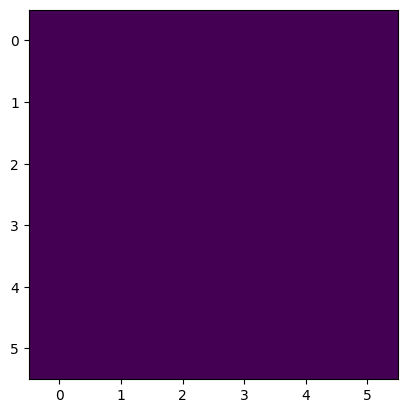

In [ ]:
#initialize a 6*6 grid
grid = np.zeros((6,6))
print(grid)

plt.imshow(grid)


[[1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5]]


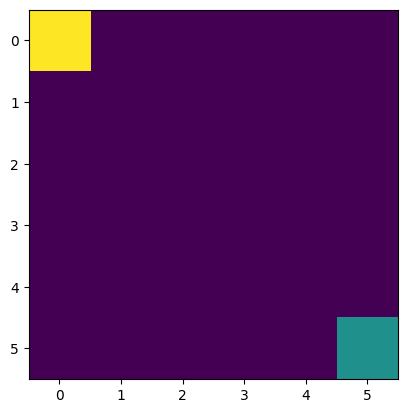

In [ ]:
start_pos = [0,0] #start position of our agent
end_pos = [5,5] #goal position of our agent
grid[tuple(start_pos)] = 1
grid[tuple(end_pos)] = 0.5
print(grid)

plt.imshow(grid)

In [ ]:
class warehouseBotEnv(gym.Env):
  metadata = { 'render.modes': [] }
  #class initializes the Warehouse robot's environment
  def __init__(self,
               timesteps = 10,
               env_type = 'Deterministic',
               start_pos = [0, 0],
               end_pos = [5, 5],
               pickup_pos=[0, 2],
               pick_up = False,
               drop_off = False,
               terminate = False,
               truncate = False):
    #env_type can either be 'deterministic' (or) 'stochastic'
    self.env_type = env_type
    self.env_width = 6
    self.env_height = 6
    self.observation_space = spaces.Discrete(self.env_height * self.env_width)
    self.valid_actions = {"DOWN": 0, "UP": 1, "RIGHT": 2, "LEFT": 3, "PICK": 4, "DROP": 5}
    self.reverse_action_map = {v: k for k, v in self.valid_actions.items()}
    self.action_space = spaces.Discrete(6)
    self.max_timesteps = timesteps
    self.timesteps = 0

    self.start_pos = start_pos
    self.shelf_pos = [(0, 4), (2, 0), (2, 2), (3, 5), (4, 1)]
    self.pick_pos = pickup_pos
    self.end_pos = end_pos
    self.current_pos = self.start_pos
    self.reward = 0
    self.pick_up = pick_up
    self.drop_off = drop_off
    self.terminate = terminate
    self.truncate = truncate

    self.space = np.zeros((self.env_height,self.env_width))
    self.space[tuple(self.start_pos)] = 1
    self.space[tuple(np.array(self.shelf_pos).T)] = 0.3
    self.space[tuple(self.pick_pos)] = 0.4
    self.space[tuple(self.end_pos)] = 0.5

  def reset(self,**kwargs):
    self.space = np.zeros((self.env_height,self.env_width))
    self.space[tuple(self.start_pos)] = 1
    self.space[tuple(np.array(self.shelf_pos).T)] = 0.3
    self.space[tuple(self.pick_pos)] = 0.4
    self.space[tuple(self.end_pos)] = 0.5
    self.current_pos = self.start_pos
    self.pick_up = False
    self.drop_off = False
    self.timesteps = 0

    observation = self.space.flatten()

    info = {}

    return observation, info

  def step(self, action):
    action_key = self.valid_actions[action]
    self.reward = 0
    self.terminate = False
    self.truncated = False

    # Handle stochastic environment
    if self.env_type == 'Stochastic':
        action_prob = np.random.uniform(0, 1)
        if action_prob <= 0.1:
            chosen_action_key = 'STAY'
        else:
            chosen_action_key = action_key
    else:
        chosen_action_key = action_key

    if chosen_action_key != 'STAY':
        match chosen_action_key:
            case 0: #DOWN
              if self.current_pos[1] < self.env_width - 1:
                self.current_pos[1] += 1
            case 1:  # UP
              if self.current_pos[1] > 0:
                self.current_pos[1] -= 1
            case 2:  # RIGHT
              if self.current_pos[0] < self.env_height - 1:  # Should be column (second index)
                self.current_pos[0] += 1
            case 3:  # LEFT
              if self.current_pos[0] > 0:
                self.current_pos[0] -= 1
            case 4:  # PICK
                if np.array_equal(self.current_pos, self.pick_pos) and not self.pick_up:
                    self.pick_up = True
                    self.reward += 5
            case 5:  # DROP
                if np.array_equal(self.current_pos, self.end_pos) and self.pick_up:
                    self.pick_up = False
                    self.drop_off = True
                    self.reward += 20
    self.current_pos = np.clip(self.current_pos, 0, [self.env_height - 1, self.env_width - 1])

    # updating space after action is taken:
    self.space = np.zeros((self.env_height, self.env_width))  # Reinitialize the space
    self.space[tuple(self.current_pos)] = 1
    self.space[tuple(np.array(self.shelf_pos).T)] = 0.3
    self.space[tuple(self.pick_pos)] = 0.4
    self.space[tuple(self.end_pos)] = 0.5

    observation = self.space.flatten()

    # Handle reward logic
    if any(np.array_equal(self.current_pos, shelf) for shelf in self.shelf_pos):
        self.reward -= 20
    else:
        self.reward -= 1

    self.timesteps += 1

    if self.timesteps >= self.max_timesteps or self.drop_off:
        self.terminate = True

    self.truncated = not np.all((np.array(self.current_pos) >= 0) & (np.array(self.current_pos) < [self.env_height, self.env_width]))

    info = {}
    return observation, self.reward, self.terminate, self.truncated, info


  def render(self):
    fig,ax = plt.subplots(figsize= (6,6))
    agent_clr = '#FFCC00'
    pickup_clr = '#4A90E2'
    dropoff_clr = '#7ED321'
    shelf_clr = '#D0021B'

    for x in range(self.env_width):
      for y in range(self.env_height):
        value = self.space[x,y]
        if value == 1:
          rect = plt.Rectangle((x,y),1,1,facecolor = agent_clr)
          ax.add_patch(rect)
          ax.text(x+0.5,y+0.5,"Agent",color = 'yellow',ha= 'center',va='center')

        if value == 0.3:
          rect = plt.Rectangle((x,y),1,1,facecolor = shelf_clr)
          ax.add_patch(rect)
          ax.text(x+0.5,y+0.5,"Shelf",color = 'red',ha= 'center',va='center')

        if value == 0.4:
          if self.pick_up == True:
            rect = plt.Rectangle((x,y),1,1,facecolor = pickup_clr)
            ax.add_patch(rect)
            ax.text(x+0.5,y+0.5,"Pick-up",color = 'blue',ha= 'center',va='center')
          else:
            rect = plt.Rectangle((x,y),1,1,facecolor = pickup_clr)
            ax.add_patch(rect)
            ax.text(x+0.5,y+0.5,"P",color = 'blue',ha= 'center',va='center')

        if value == 0.5:
          if self.drop_off == True:
            rect = plt.Rectangle((x,y),1,1,facecolor = dropoff_clr)
            ax.add_patch(rect)
            ax.text(x+0.5,y+0.5,"Drop-off",color = 'green',ha= 'center',va='center')
          else:
            rect = plt.Rectangle((x,y),1,1,facecolor = dropoff_clr)
            ax.add_patch(rect)
            ax.text(x+0.5,y+0.5,"D",color = 'green',ha= 'center',va='center')

    ax.set_xlim(0,self.env_width)
    ax.set_ylim(0,self.env_height)
    ax.set_xticks(np.arange(self.env_width+1))
    ax.set_yticks(np.arange(self.env_height+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()



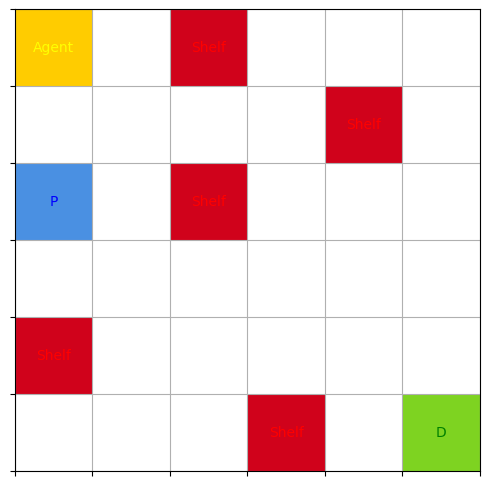

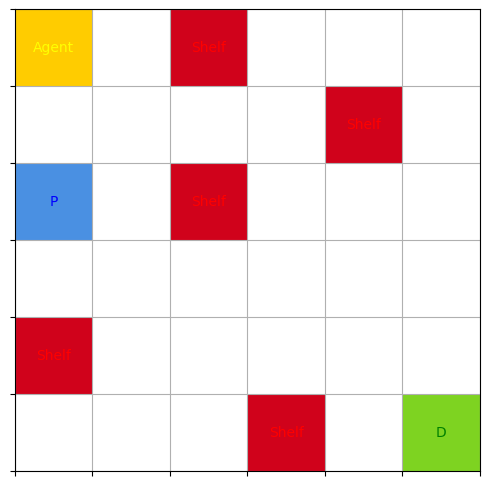

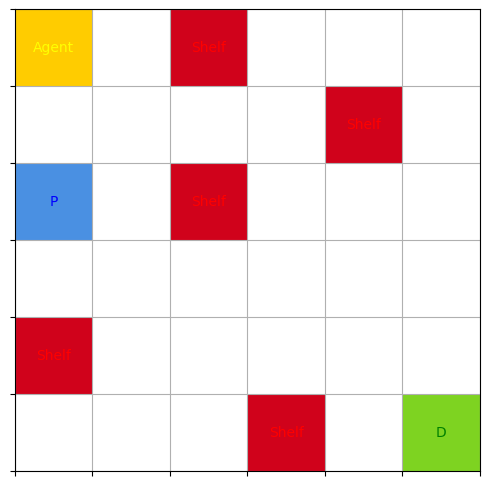

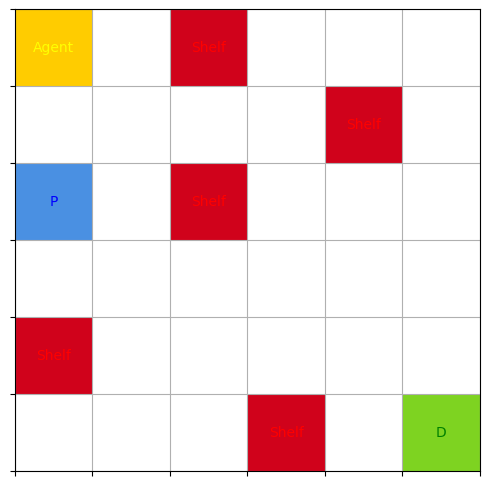

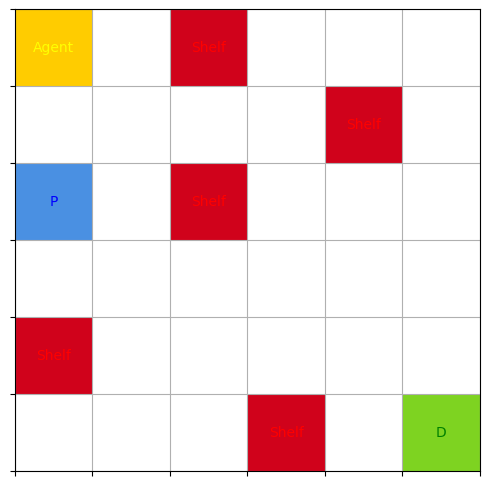

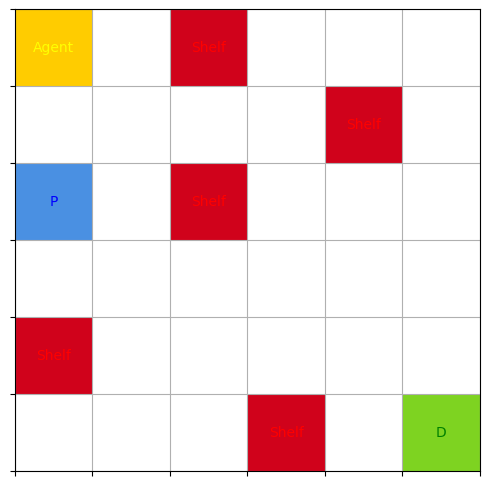

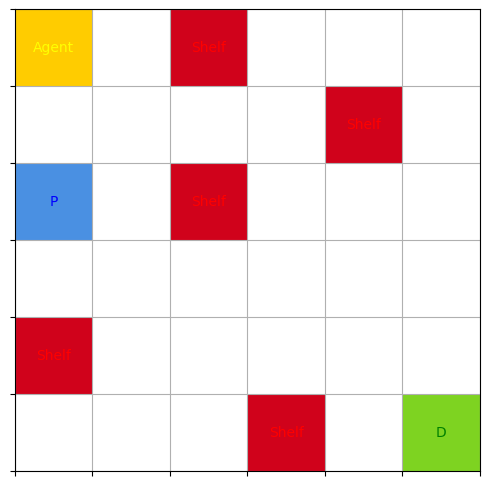

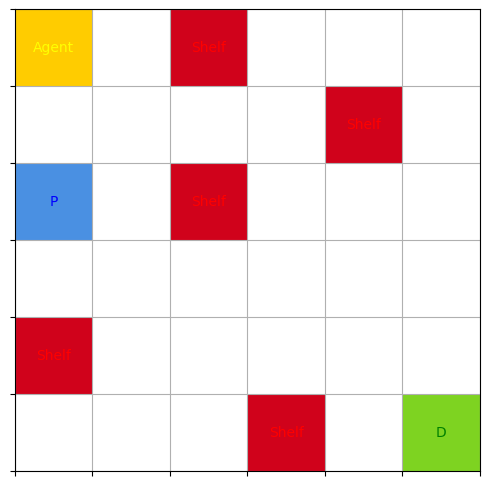

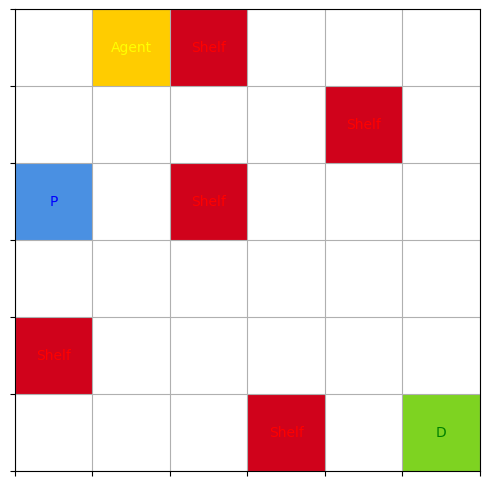

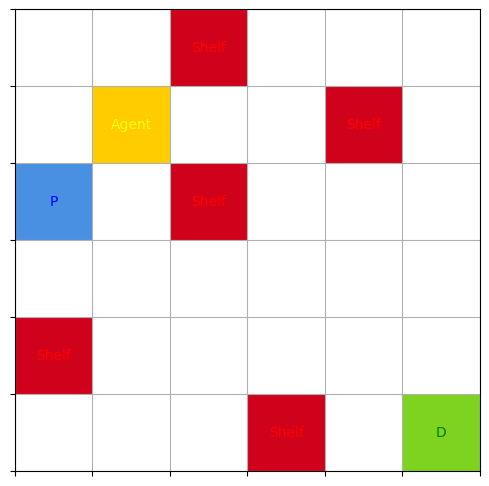

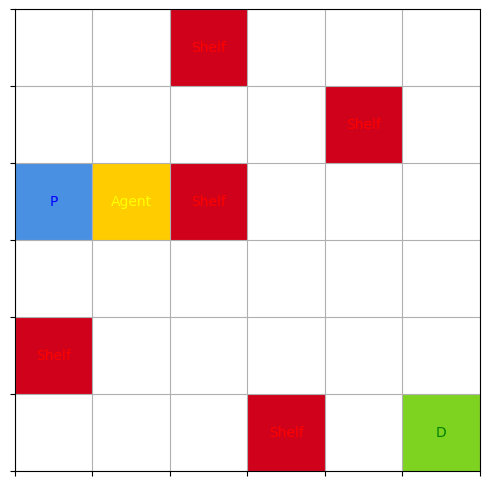

In [ ]:
env = warehouseBotEnv(timesteps = 10,env_type = 'Stochastic')

terminated, truncated = False, False
obs, info = env.reset()
env.render()

while not (terminated or truncated):
  action = env.valid_actions[np.random.choice(list(env.valid_actions.keys()))]
  action = env.reverse_action_map[action]
  obs, reward, terminated, truncated, info = env.step(action)
  env.render()

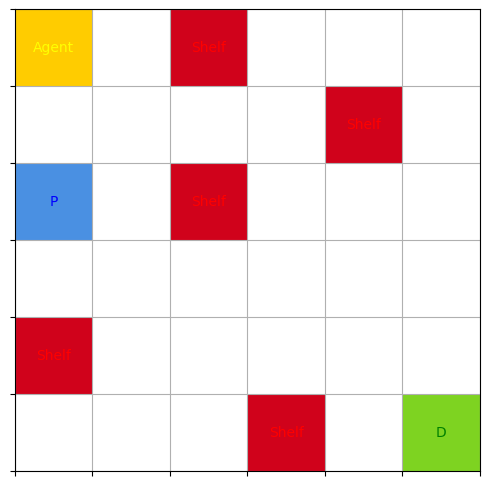

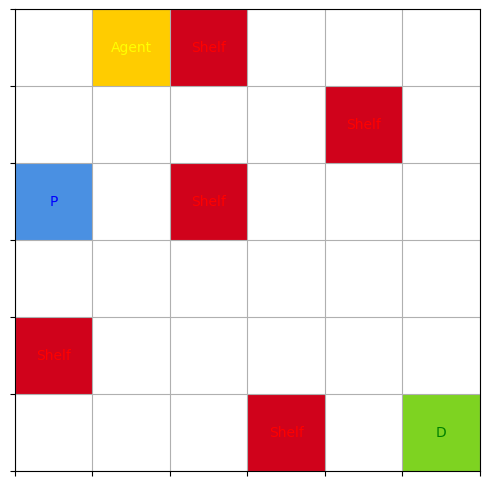

In [ ]:
env = warehouseBotEnv(timesteps = 10,env_type = 'Deterministic')
terminated, truncated = False, False
obs, info = env.reset()
env.render()

if not (terminated or truncated):
  action = "RIGHT"
  observation, reward, terminated, truncated, info = env.step(action)
  env.render()

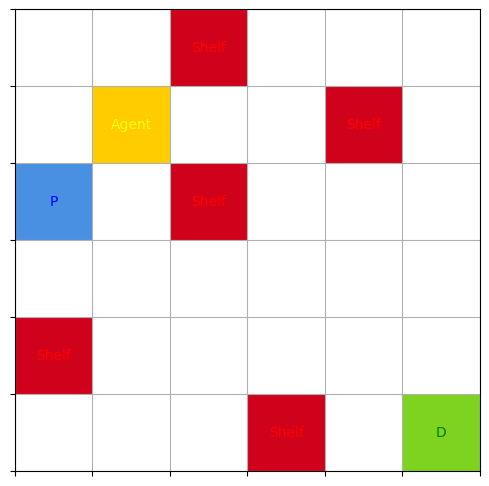

In [ ]:
if not (terminated or truncated):
  action = "DOWN"
  observation, reward, terminated, truncated, info = env.step(action)
  env.render()

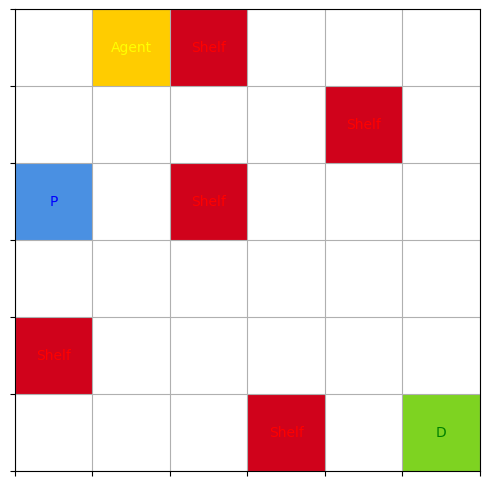

In [ ]:
if not (terminated or truncated):
  action = "UP"
  observation, reward, terminated, truncated, info = env.step(action)
  env.render()

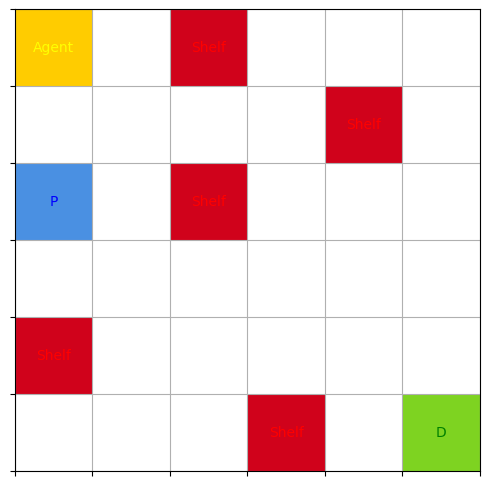

In [ ]:
if not (terminated or truncated):
  action = "LEFT"
  observation, reward, terminated, truncated, info = env.step(action)
  env.render()

In [ ]:
class RandomAgent:

  def __init__(self, env):
    self.env = env
    self.observation = env.observation_space
    self.action_space = env.action_space.n

  def step(self, obs):
    # We need to pass the observation and then return the optimal action, in this case it is random
    return np.random.choice(self.action_space)

Action: 1 , Reward: -1 , Done: False


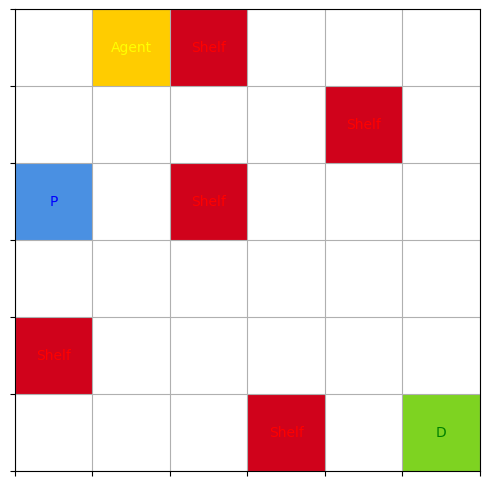

Action: 5 , Reward: -1 , Done: False


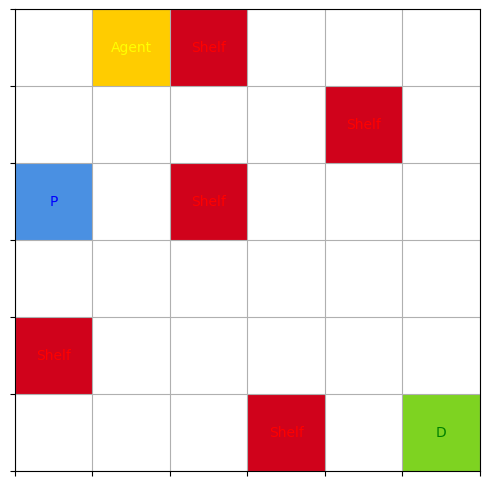

Action: 2 , Reward: -20 , Done: False


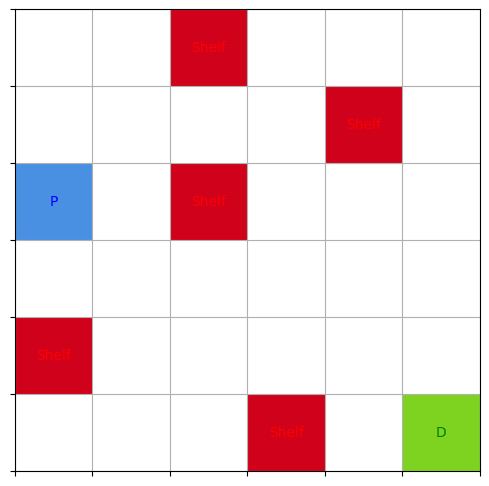

Action: 1 , Reward: -20 , Done: False


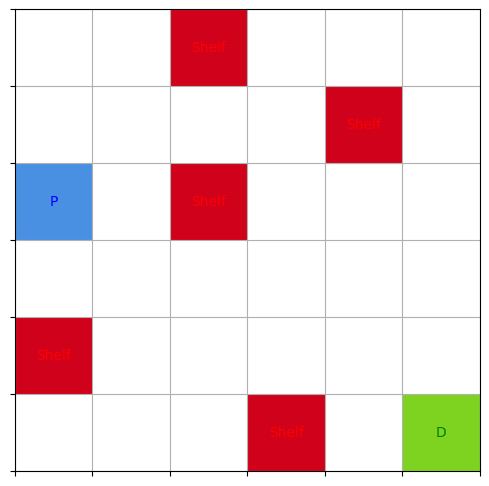

Action: 1 , Reward: -20 , Done: False


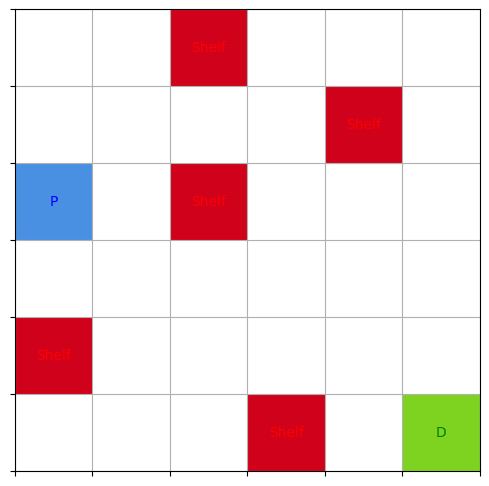

Action: 2 , Reward: -1 , Done: False


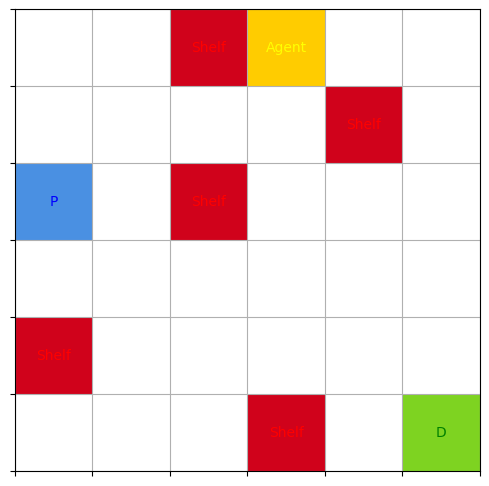

Action: 2 , Reward: -1 , Done: False


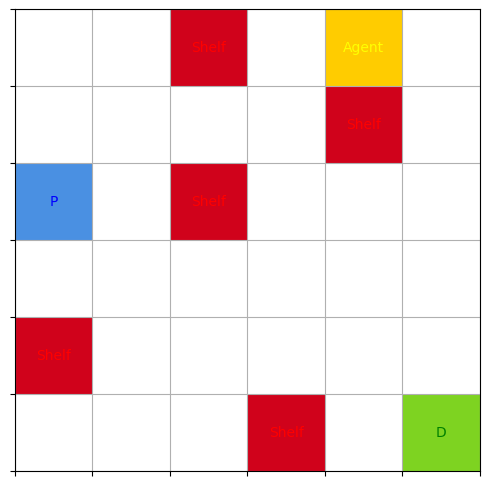

Action: 5 , Reward: -1 , Done: False


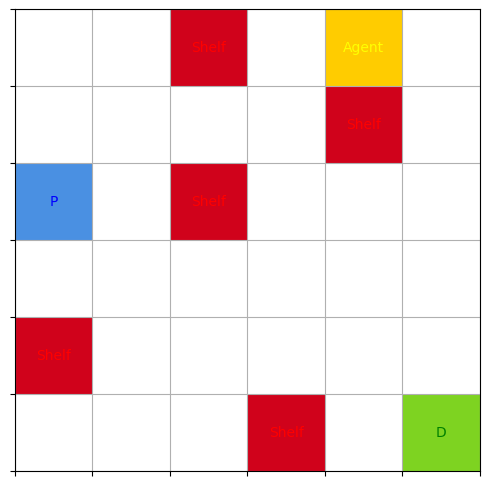

Action: 5 , Reward: -1 , Done: False


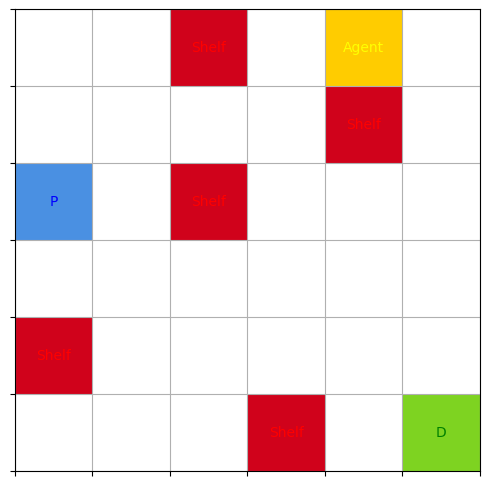

Action: 1 , Reward: -1 , Done: False


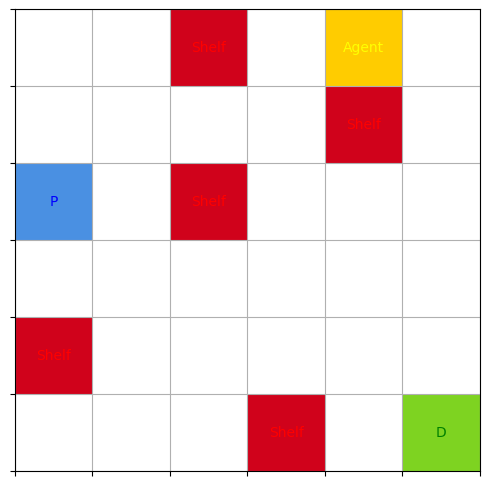

Action: 5 , Reward: -1 , Done: False


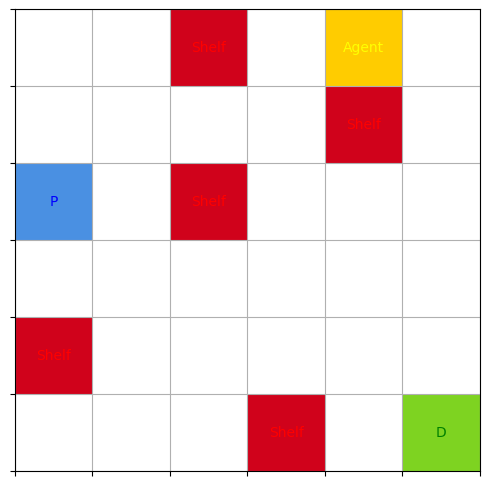

Action: 3 , Reward: -1 , Done: False


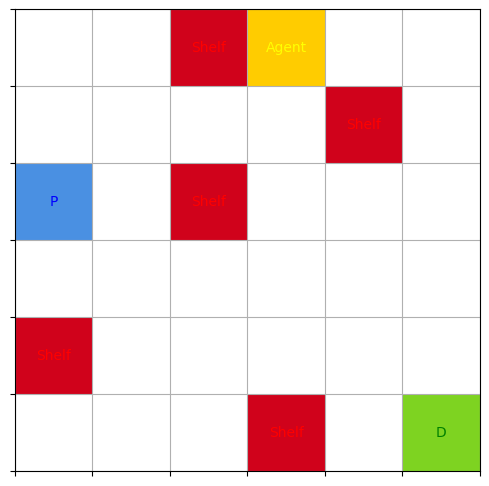

Action: 5 , Reward: -1 , Done: False


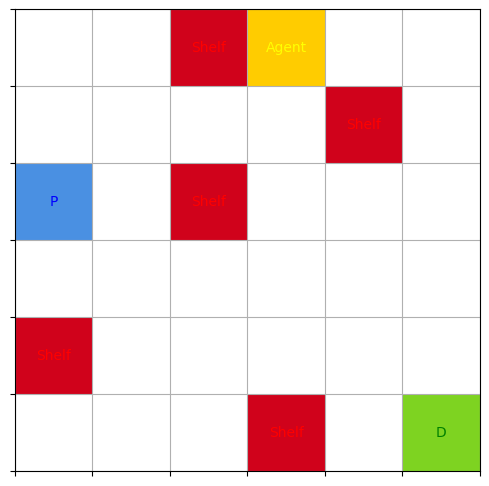

Action: 0 , Reward: -1 , Done: False


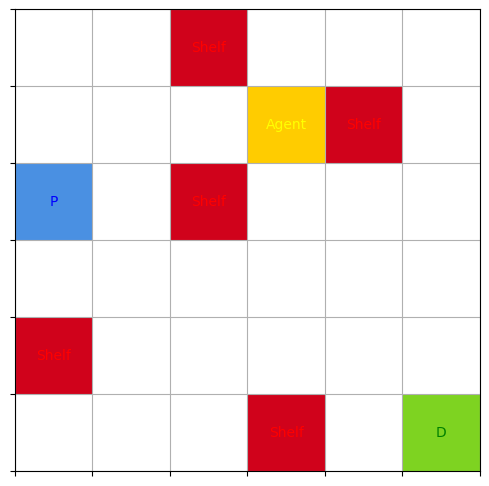

Action: 2 , Reward: -20 , Done: False


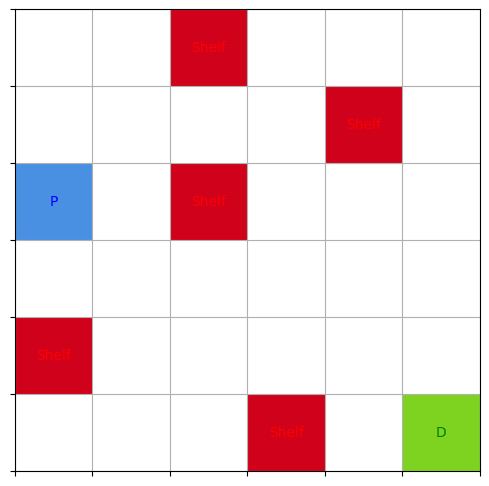

Action: 4 , Reward: -20 , Done: False


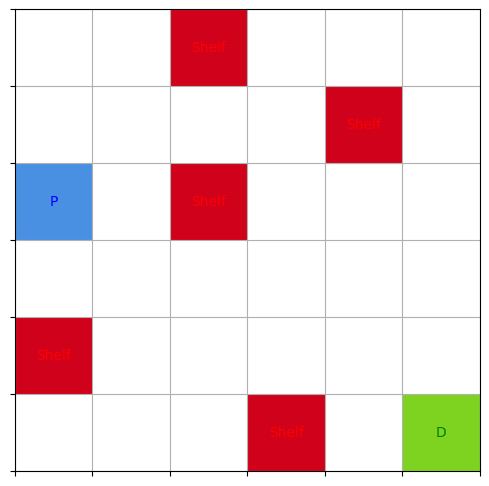

Action: 3 , Reward: -1 , Done: False


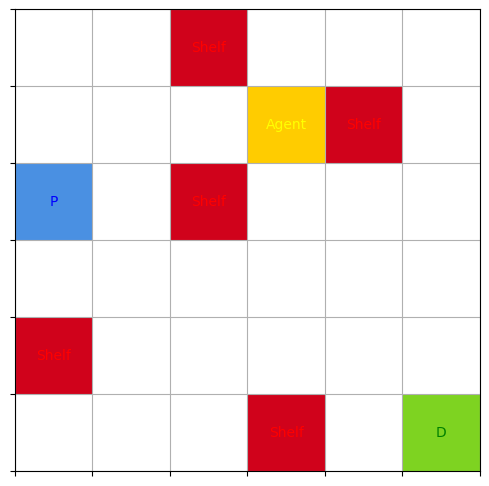

Action: 1 , Reward: -1 , Done: False


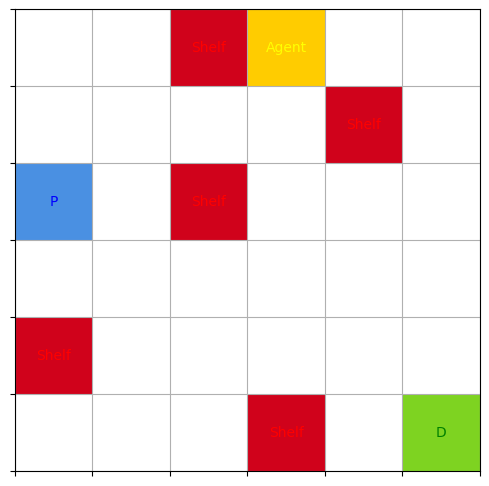

Action: 1 , Reward: -1 , Done: False


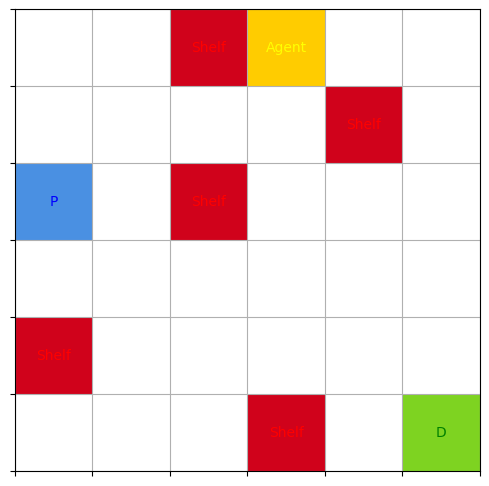

Action: 5 , Reward: -1 , Done: True


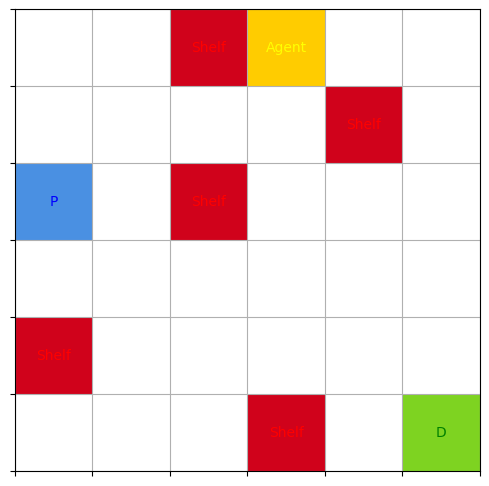

In [ ]:
if __name__ == "__main__":
  env = warehouseBotEnv(timesteps=20,  env_type='Deterministic')
  agent = RandomAgent(env)

  obs, info = env.reset()
  terminated, truncated = False, False

  reverse_action_map = {v: k for k, v in env.valid_actions.items()}
  while not(terminated or truncated):
    action = agent.step(obs)
    obs, reward, terminated, truncated, info = env.step(reverse_action_map[action])
    print('Action:', action, ', Reward:', reward, ', Done:', terminated)
    env.render()


Action: 0 , Reward: -1 , Done: False


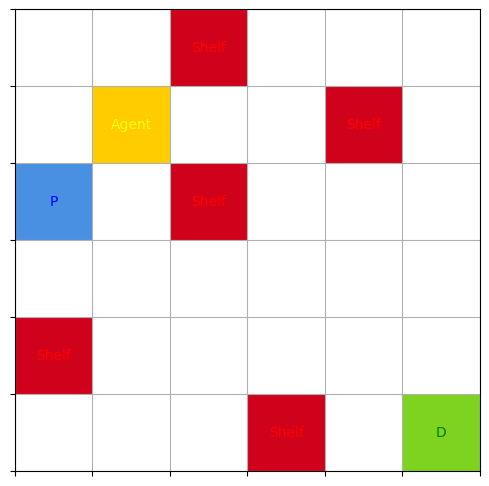

Action: 3 , Reward: -1 , Done: False


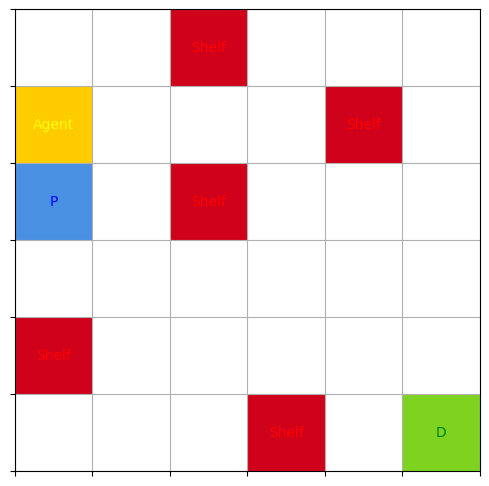

Action: 3 , Reward: -1 , Done: False


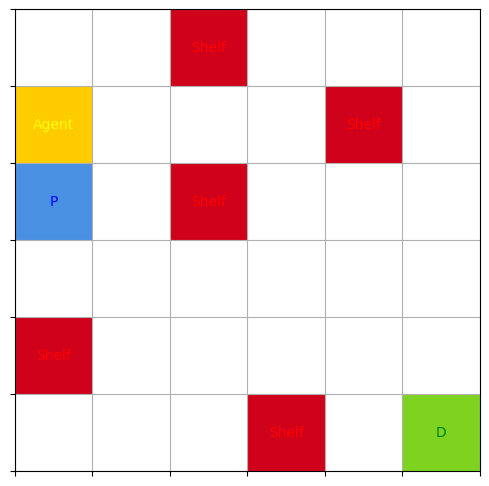

Action: 2 , Reward: -1 , Done: False


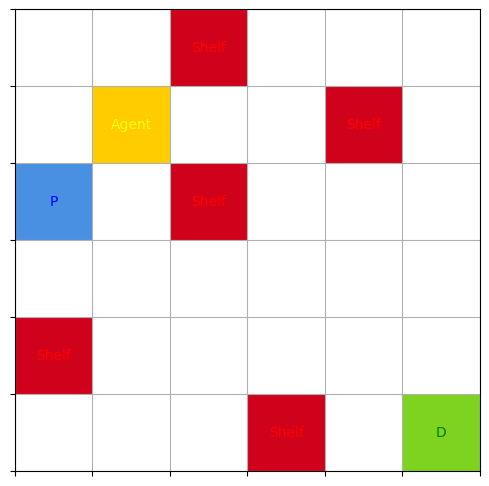

Action: 0 , Reward: -1 , Done: False


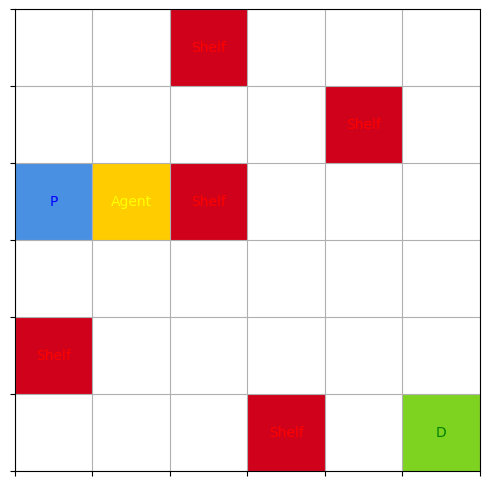

Action: 1 , Reward: -1 , Done: False


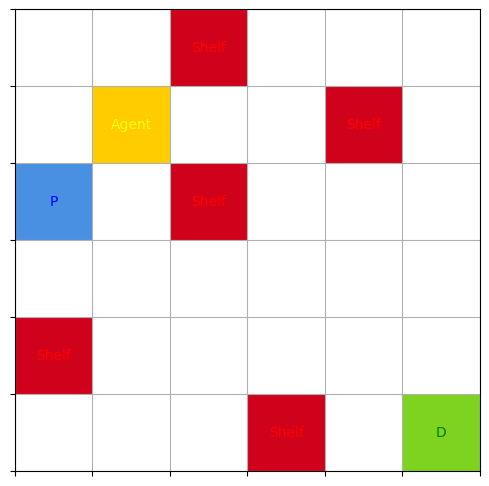

Action: 0 , Reward: -1 , Done: False


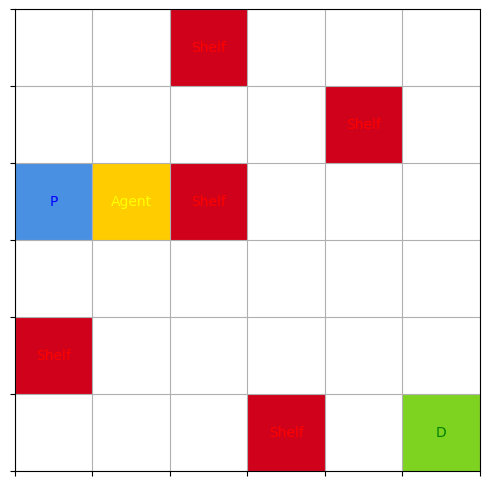

Action: 5 , Reward: -1 , Done: False


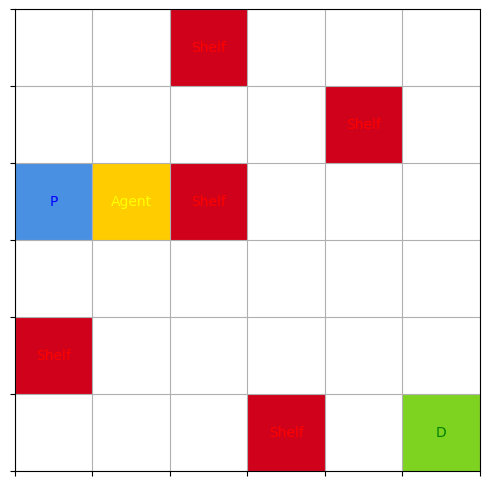

Action: 2 , Reward: -20 , Done: False


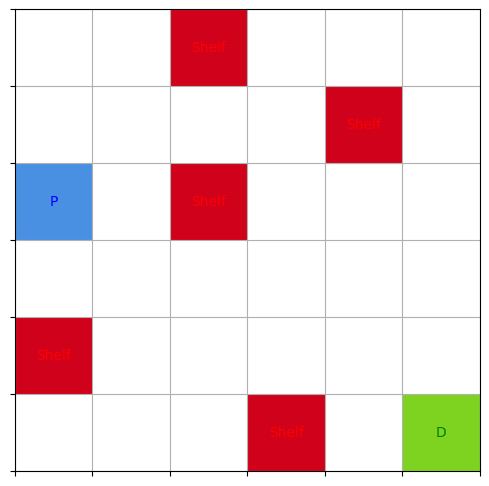

Action: 4 , Reward: -20 , Done: True


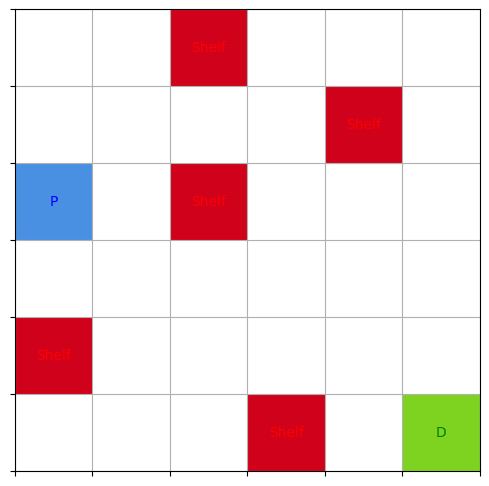

In [ ]:
if __name__ == '__main__':
  env = warehouseBotEnv(env_type = "Stochastic")
  agent = RandomAgent(env)

  obs, info = env.reset()
  terminated, truncated = False, False

  reverse_action_map = {v: k for k, v in env.valid_actions.items()}
  while not terminated:
    action = agent.step(obs)
    obs, reward, terminated, truncated, info = env.step(reverse_action_map[action])
    print('Action:', action, ', Reward:', reward, ', Done:', terminated)
    env.render()

In [ ]:
import random
import pickle

1. Q-Learning Algorithm

In [ ]:
n_observations = env.observation_space.n
n_actions = env.action_space.n

In [ ]:
qtable_deterministic = np.zeros((n_observations, n_actions))
qtable_stochastic = np.zeros((n_observations, n_actions))

In [ ]:
n_episodes = 1000
max_iter_per_episode = 100
epsilon = 0.99
epsilon_decay_rate = 0.01
min_epsilon = 0.01
alpha = 0.1
gamma = 0.6
rewards = []


In [ ]:
def Qtable(qtable,
           env_type='deterministic',
           n_episodes=1000,
           max_iter_per_episode=100,
           epsilon_values=[],
           epsilon=0.99,
           epsilon_decay_rate=0.01,
           min_epsilon=0.01,
           alpha=0.1,
           gamma=0.6,
           rewards=[]):

    # Set environment type (deterministic or stochastic)
    if env_type == 'deterministic':
        env = warehouseBotEnv(timesteps=10, env_type='Deterministic')
    else:
        env = warehouseBotEnv(timesteps=10, env_type='Stochastic')

    reverse_action_map = {v: k for k, v in env.valid_actions.items()}

    # Loop for each episode
    for e in range(n_episodes):
        current_state, _ = env.reset()
        current_state = np.argmax(current_state)  # Get the state index
        done = False
        total_rewards = 0

        # Loop through each step in the episode
        for s in range(max_iter_per_episode):
            # Epsilon-greedy policy
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(qtable[current_state, :])  # Exploit the learned policy

            # Corrected: Use parentheses with `get()` to access reverse action map
            action_key = reverse_action_map.get(action, None)

            if action_key is None:
                raise ValueError(f"Invalid action {action} at state {current_state}")

            # Take action in the environment
            obs, reward, terminated, truncated, info = env.step(action_key)
            obs = np.argmax(obs)  # Get the state index from observation

            # Q-learning update rule
            qtable[current_state, action] = qtable[current_state, action] + alpha * (
                reward + gamma * np.max(qtable[obs, :]) - qtable[current_state, action])
            total_rewards += reward
            current_state = obs  # Move to the next state

            # If the episode ends, break the loop
            if terminated or truncated:
                break

        # After each episode, decay epsilon and store total rewards
        epsilon = max(min_epsilon, epsilon * (1 - epsilon_decay_rate))
        epsilon_values.append(epsilon)
        rewards.append(total_rewards)

    return qtable, rewards, epsilon_values

In [ ]:
def plot_total_reward_per_episode(rewards, title="Total Reward per Episode"):
    episodes = range(len(rewards))
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.show()

In [ ]:
def plot_epsilon_decay(epsilon_values, title="Epsilon Decay"):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(epsilon_values)), epsilon_values)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(title)
    plt.show()

Initial Q-table (deterministic):
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Final Q-table (deterministic):
[[ -2.14398352  -2.13873051  -2.14949941  -2.14450648  -2.14813339
   -2.14466424]
 [ -2.19981468  -2.18816115  -2.19611613  -2.19061033  -2.18747162
   -2.19663373]
 [  0.      

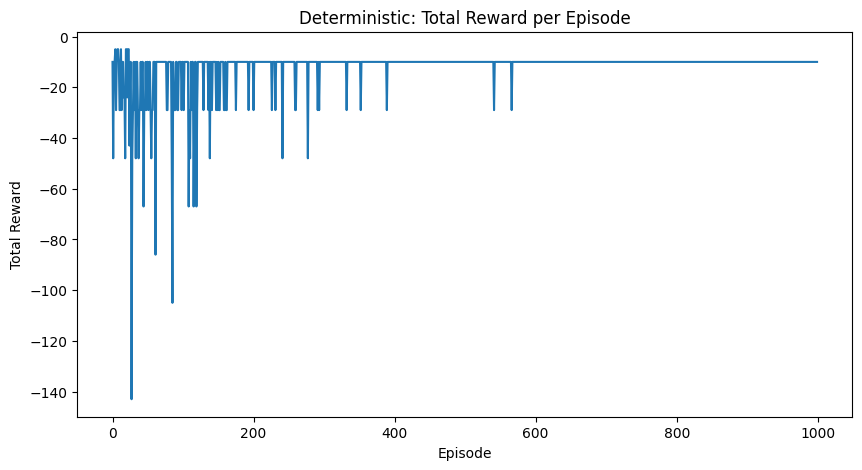

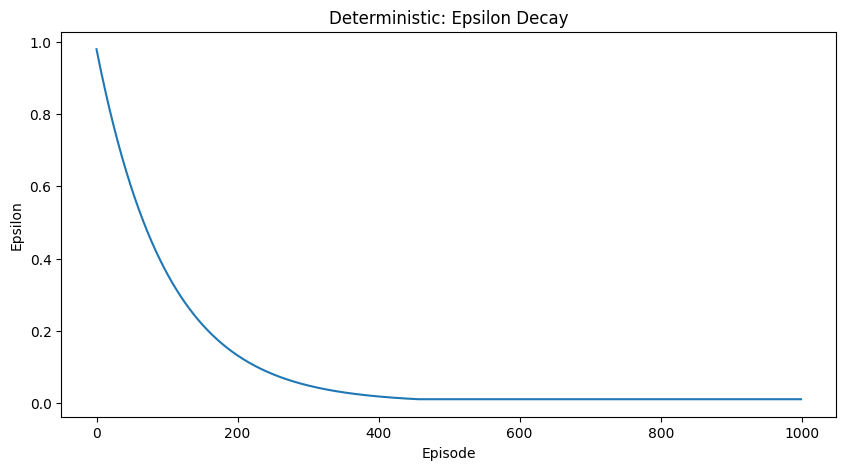

In [ ]:
# 1. Deterministic Environment
print("Initial Q-table (deterministic):")
qtable_deterministic = np.zeros((n_observations, n_actions))
print(qtable_deterministic)

qtable_deterministic, drewards, depsilon_values = Qtable(qtable_deterministic)

print("\nFinal Q-table (deterministic):")
print(qtable_deterministic)

with open('qtable_deterministic.pkl', 'wb') as f:
    pickle.dump(qtable_deterministic, f)
print("\nSaved Q-table (deterministic) as a pickle file")

# Plot rewards and epsilon decay for deterministic environment
plot_total_reward_per_episode(drewards, title="Deterministic: Total Reward per Episode")
plot_epsilon_decay(depsilon_values, title="Deterministic: Epsilon Decay")

Initial Q-table (stochastic):
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Final Q-table (stochastic):
[[ -2.06647428  -2.04760526  -2.04875151  -2.04863551  -2.04960137
   -2.04987639]
 [ -2.12555564  -2.10561417  -2.11481827  -2.11569526  -2.1158358
   -2.11632959]
 [  0.           0.

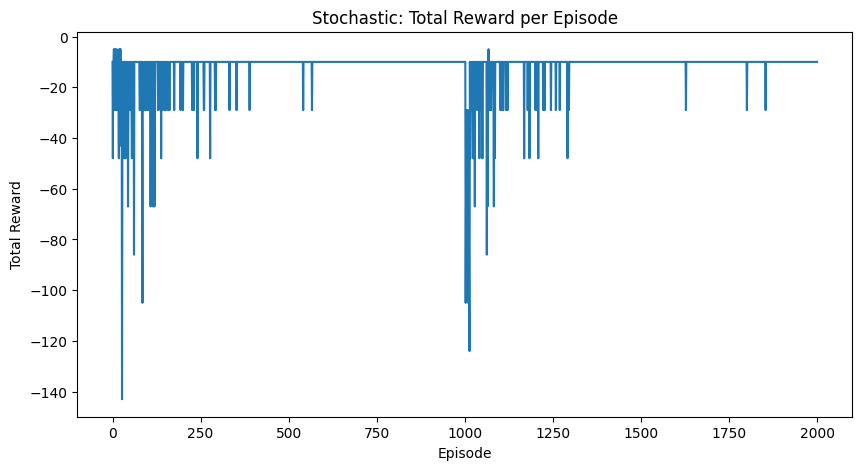

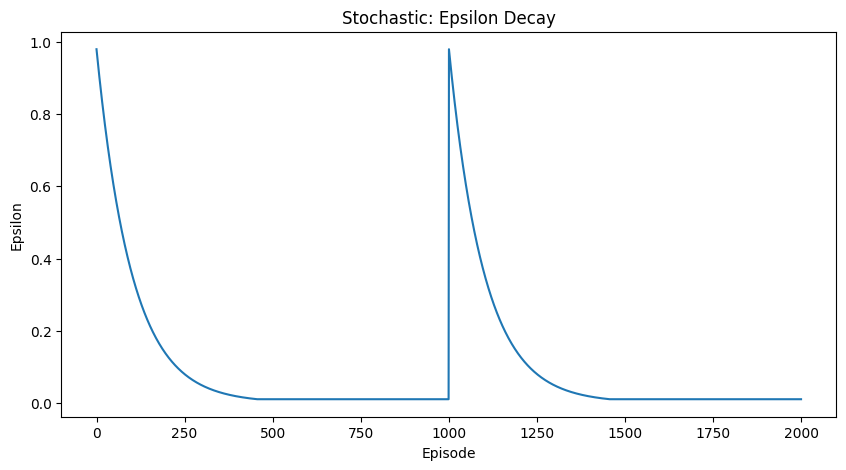

In [ ]:
print("Initial Q-table (stochastic):")
qtable_stochastic = np.zeros((n_observations, n_actions))
print(qtable_stochastic)

# Train the agent in the stochastic environment
qtable_stochastic, srewards, sepsilon_values = Qtable(qtable_stochastic, env_type='stochastic')

print("\nFinal Q-table (stochastic):")
print(qtable_stochastic)

# Save the trained Q-table for stochastic environment
with open('qtable_stochastic.pkl', 'wb') as f:
    pickle.dump(qtable_stochastic, f)
print("\nSaved Q-table (stochastic) as a pickle file")

# Plot rewards and epsilon decay for stochastic environment
plot_total_reward_per_episode(srewards, title="Stochastic: Total Reward per Episode")
plot_epsilon_decay(sepsilon_values, title="Stochastic: Epsilon Decay")


In [ ]:
# hyperparameter tuning

!pip install optuna

[I 2024-09-27 03:06:43,237] A new study created in memory with name: no-name-d759444a-fcfd-42af-b91e-9bf5d34d2292
[I 2024-09-27 03:06:48,972] Trial 0 finished with value: -93930.0 and parameters: {'gamma': 0.9286538364844754, 'epsilon_decay_rate': 0.04907994116978615}. Best is trial 0 with value: -93930.0.
[I 2024-09-27 03:06:53,654] Trial 1 finished with value: -139350.0 and parameters: {'gamma': 0.7527943384943674, 'epsilon_decay_rate': 0.0198557251648891}. Best is trial 0 with value: -93930.0.
[I 2024-09-27 03:07:01,494] Trial 2 finished with value: -182964.0 and parameters: {'gamma': 0.5340002046995025, 'epsilon_decay_rate': 0.01922421746591016}. Best is trial 0 with value: -93930.0.


Best parameters: {'gamma': 0.9286538364844754, 'epsilon_decay_rate': 0.04907994116978615}
Best value: -93930.0


Best Deterministic: Total Reward per Episode


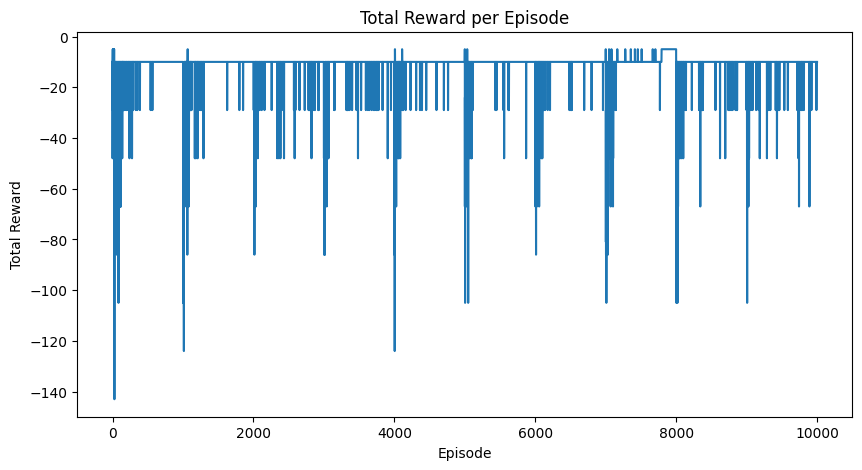

Best Deterministic: Epsilon Decay


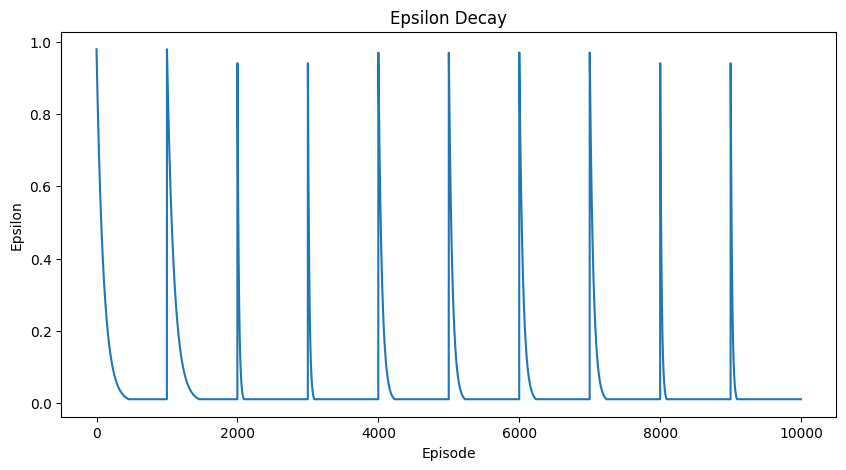

Best Stochastic: Total Reward per Episode


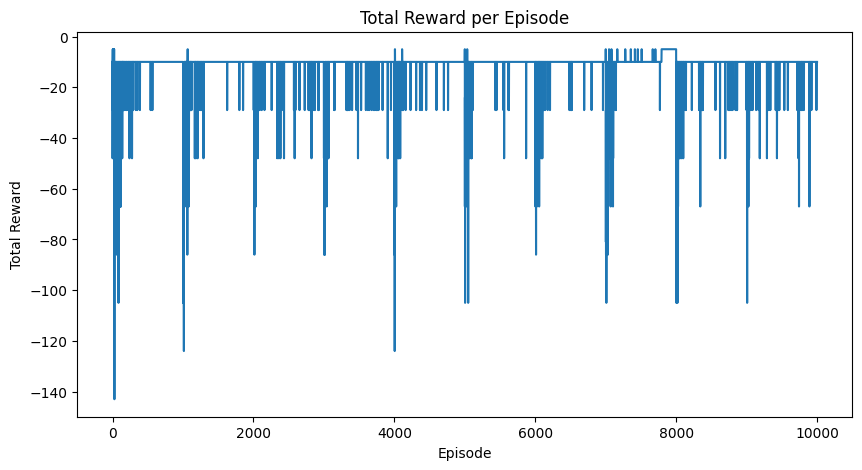

Best Stochastic: Epsilon Decay


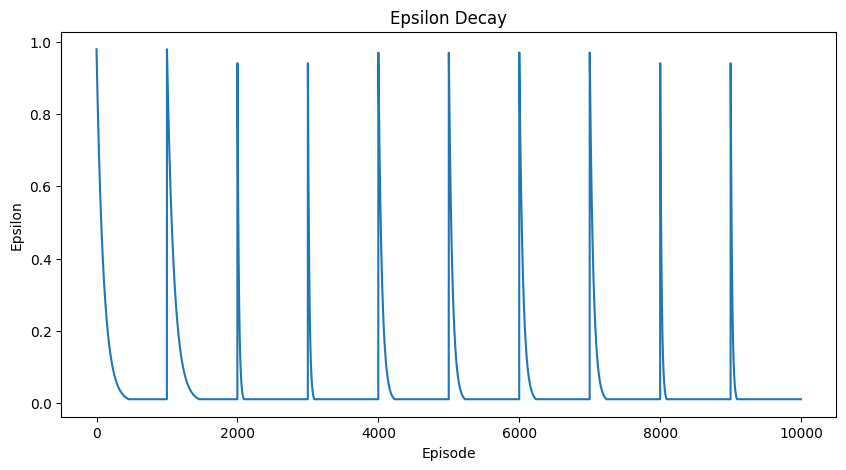

In [ ]:
import optuna

def objective(trial):
    # Suggest values for gamma and epsilon decay rate
    gamma = trial.suggest_float("gamma", 0.5, 0.99)
    epsilon_decay_rate = trial.suggest_float("epsilon_decay_rate", 0.01, 0.1)

    # Initialize Q-tables for deterministic and stochastic environments
    qtable_deterministic = np.zeros((n_observations, n_actions))
    qtable_stochastic = np.zeros((n_observations, n_actions))

    # Run Q-learning on deterministic environment
    qtable_deterministic, drewards, depsilon_values = Qtable(
        qtable_deterministic, env_type='deterministic',
        epsilon_decay_rate=epsilon_decay_rate, gamma=gamma
    )

    # Run Q-learning on stochastic environment
    qtable_stochastic, srewards, sepsilon_values = Qtable(
        qtable_stochastic, env_type='stochastic',
        epsilon_decay_rate=epsilon_decay_rate, gamma=gamma
    )

    # Calculate the total reward across both environments
    total_reward = np.sum(drewards) + np.sum(srewards)

    # Return the total reward as the objective to maximize
    return total_reward

# Set up Optuna study to maximize total rewards
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

# Print the best parameters and value found
print(f"Best parameters: {study.best_params}")
print(f"Best value: {study.best_value}")

# Plot the optimization history and parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

# Plot results from the best trial
best_trial = study.best_trial

# Run Q-learning with the best hyperparameters
best_qtable_deterministic, best_drewards, best_depsilon_values = Qtable(
    np.zeros((n_observations, n_actions)), env_type='deterministic',
    epsilon_decay_rate=best_trial.params['epsilon_decay_rate'],
    gamma=best_trial.params['gamma']
)

best_qtable_stochastic, best_srewards, best_sepsilon_values = Qtable(
    np.zeros((n_observations, n_actions)), env_type='stochastic',
    epsilon_decay_rate=best_trial.params['epsilon_decay_rate'],
    gamma=best_trial.params['gamma']
)

# Visualize the total reward per episode and epsilon decay for deterministic setup
print("Best Deterministic: Total Reward per Episode")
plot_total_reward_per_episode(best_drewards)
print("Best Deterministic: Epsilon Decay")
plot_epsilon_decay(best_depsilon_values)

# Visualize the total reward per episode and epsilon decay for stochastic setup
print("Best Stochastic: Total Reward per Episode")
plot_total_reward_per_episode(best_srewards)
print("Best Stochastic: Epsilon Decay")
plot_epsilon_decay(best_sepsilon_values)


In [ ]:
def doubleQLearning(qtable1,
                    qtable2,
                    env_type='deterministic',
                    n_episodes=5000,
                    max_iter_per_episode=100,
                    epsilon_values=[],
                    epsilon=0.99,
                    epsilon_decay=0.05,
                    min_epsilon=0.1,
                    alpha=0.1,
                    gamma=0.6,
                    rewards=[]):

    # Set environment type (deterministic or stochastic)
    if env_type == 'deterministic':
        env = warehouseBotEnv(timesteps=10, env_type='Deterministic')
    else:
        env = warehouseBotEnv(timesteps=10, env_type='Stochastic')

    # Reverse the action map once (to map environment actions to indices)
    reverse_action_map = {v: k for k, v in env.valid_actions.items()}

    # Loop for each episode
    for e in range(n_episodes):
        current_state = env.reset()
        current_state = np.argmax(current_state[0])  # Get the state index from observation
        total_rewards = 0

        for i in range(max_iter_per_episode):
            # Epsilon-greedy policy
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                # Combine Q-values from both Q-tables for exploitation
                qvalue = qtable1[current_state, :] + qtable2[current_state, :]
                action = np.argmax(qvalue)  # Exploitation

            # Convert action index to environment action using reverse mapping
            env_action = reverse_action_map.get(action)
            obs, reward, terminated, truncated, info = env.step(env_action)
            obs = np.argmax(obs)  # Convert observation to state index

            # Randomly update either Q1 or Q2 based on the Double Q-Learning rule
            if np.random.uniform(0, 1) < 0.5:
                # Update Q1
                next_best_action = np.argmax(qtable1[obs, :])
                qtable1[current_state, action] += alpha * (
                    reward + gamma * qtable2[obs, next_best_action] - qtable1[current_state, action])
            else:
                # Update Q2
                next_best_action = np.argmax(qtable2[obs, :])
                qtable2[current_state, action] += alpha * (
                    reward + gamma * qtable1[obs, next_best_action] - qtable2[current_state, action])

            total_rewards += reward
            current_state = obs  # Move to the next state

            # End the episode if the environment terminates or truncates
            if terminated or truncated:
                break

        # Epsilon decay after each episode
        epsilon = max(min_epsilon, epsilon * (1 - epsilon_decay))
        epsilon_values.append(epsilon)
        rewards.append(total_rewards)



    return qtable1, qtable2, rewards, epsilon_values


Initial Q-tables (deterministic):
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]

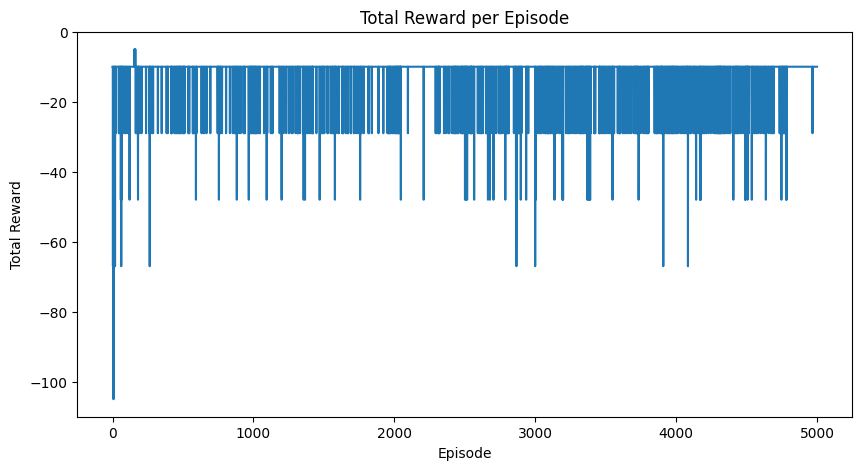

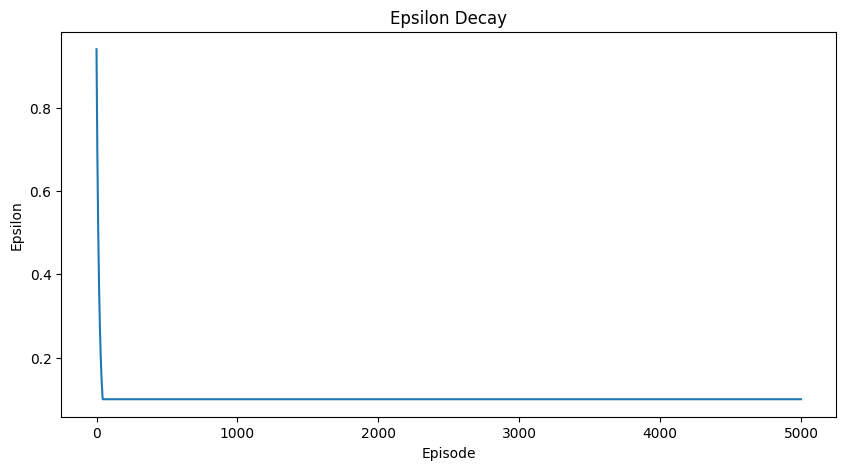


Saved q-tables (deterministic) as pickle files


In [ ]:
qtable1_deterministic = np.zeros((n_observations,n_actions))
qtable2_deterministic = np.zeros((n_observations,n_actions))



print("Initial Q-tables (deterministic):")
print(qtable1_deterministic)
print(qtable2_deterministic)

qtable1_deterministic, qtable2_deterministic, ddqrewards, ddqepsilon_values = doubleQLearning(qtable1_deterministic, qtable2_deterministic, env_type = 'deterministic')

print("\nFinal Q-tables (deterministic):")
print(qtable1_deterministic)
print(qtable2_deterministic)

plot_total_reward_per_episode(ddqrewards)
print("\n")
plot_epsilon_decay(ddqepsilon_values)

with open('qtable_deterministic_double_q1.pkl', 'wb') as f:
    pickle.dump(qtable1_deterministic, f)
with open('qtable_deterministic_double_q2.pkl', 'wb') as f:
    pickle.dump(qtable1_deterministic, f)

print("\nSaved q-tables (deterministic) as pickle files")

Initial Q-tables (stochastic):
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [

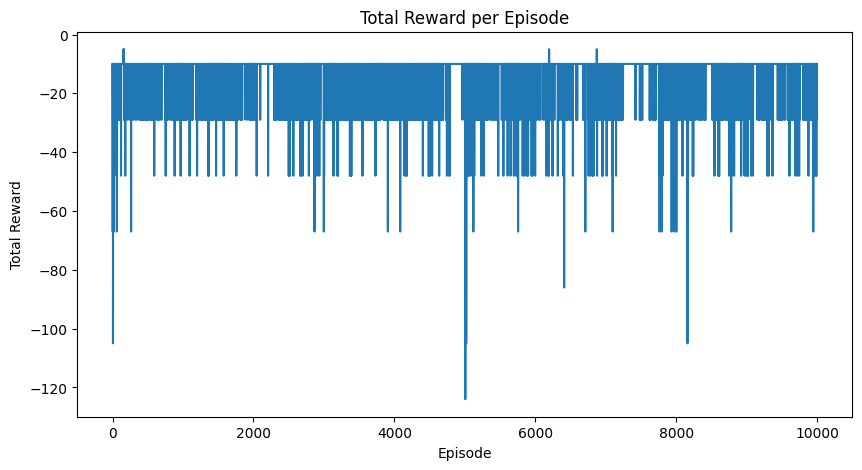

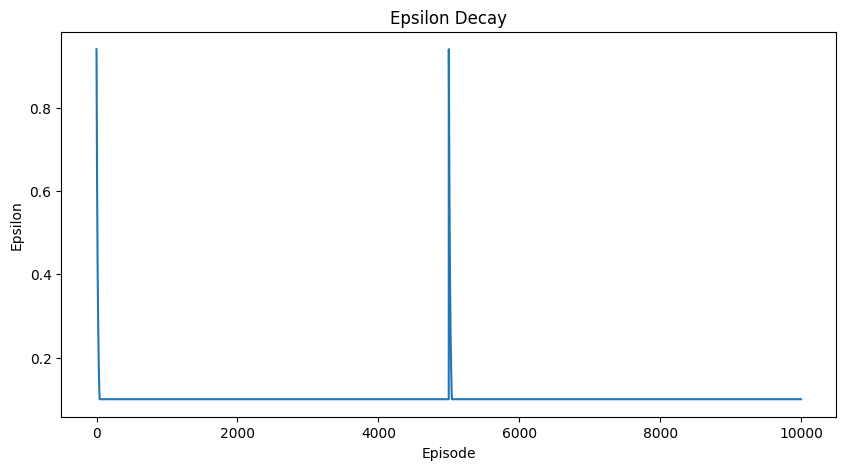


Saved q-tables (stochastic) as pickle files


In [ ]:
qtable1_stochastic = np.zeros((n_observations,n_actions))
qtable2_stochastic = np.zeros((n_observations,n_actions))


print("Initial Q-tables (stochastic):")
print(qtable1_stochastic)
print(qtable2_stochastic)

qtable1_stochastic, qtable2_stochastic, sdqrewards, sdqepsilon_values = doubleQLearning(qtable1_stochastic, qtable2_stochastic, env_type = 'stochastic')

print("\nFinal Q-tables (stochastic):")
print(qtable1_stochastic)
print(qtable2_stochastic)

plot_total_reward_per_episode(sdqrewards)
print("\n")
plot_epsilon_decay(sdqepsilon_values)

with open('qtable_stochastic_double_q1.pkl', 'wb') as f:
    pickle.dump(qtable1_stochastic, f)
with open('qtable_stochastic_double_q2.pkl', 'wb') as f:
    pickle.dump(qtable2_stochastic, f)

print("\nSaved q-tables (stochastic) as pickle files")

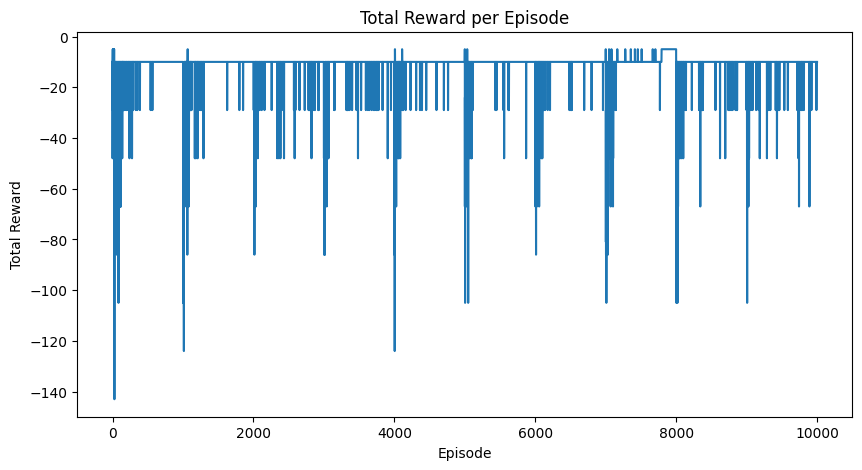

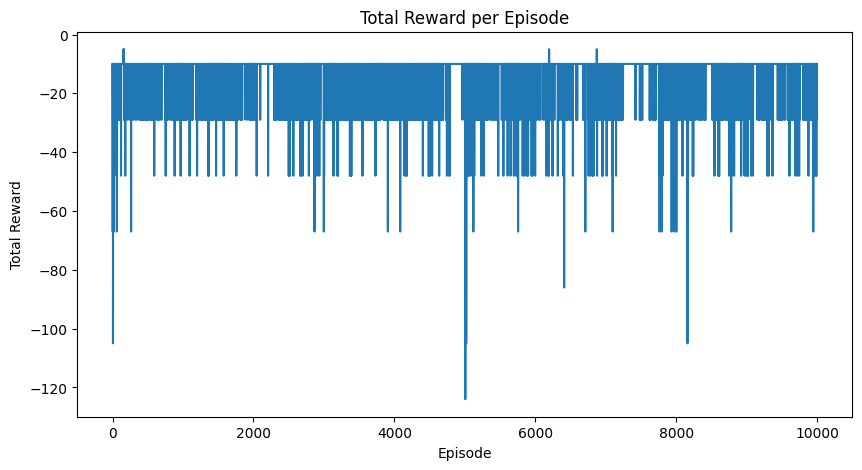

In [ ]:
# Comparison (deterministic):

plot_total_reward_per_episode(drewards)
print("\n")
plot_total_reward_per_episode(ddqrewards)

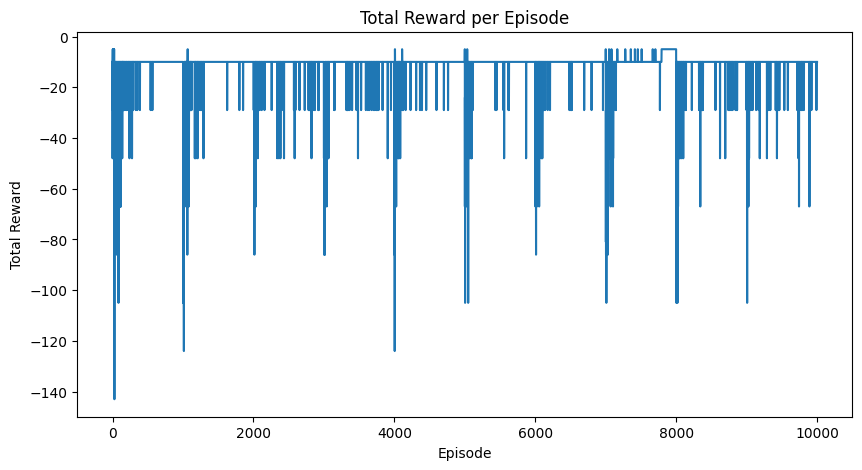

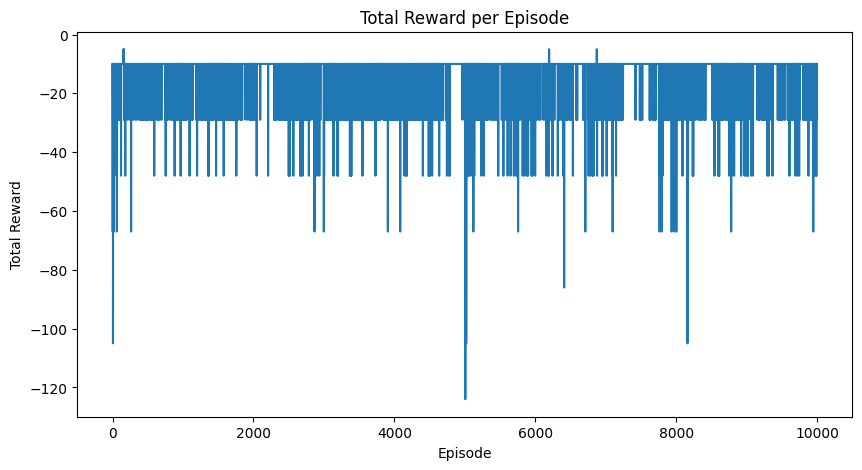

In [ ]:
# Comparison (stochastic)
plot_total_reward_per_episode(srewards)
print("\n")
plot_total_reward_per_episode(sdqrewards)

**References:**
* https://python-data-science.readthedocs.io/en/latest/reinforcement.html
* [Reference video and .ipynb file shared by professor](https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2024%5FFall%5FRL%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Visualization&ga=1)
* [Reference video and .ipynb file shared by TA](https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2024%5FFall%5FRL%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Demo&ga=1)
* [Tutorial by Hugging Face](https://huggingface.co/learn/deep-rl-course/unit2/introduction)
* [Medium article 1](https://medium.com/data-science-in-your-pocket/how-to-create-a-custom-openai-gym-environment-with-codes-fb5de015de3c)
* [Medium article 2](https://medium.com/@paulswenson2/an-introduction-to-building-custom-reinforcement-learning-environment-using-openai-gym-d8a5e7cf07ea)
* [Datacamp article](https://www.datacamp.com/tutorial/reinforcement-learning-python-introduction)
* [Q-Learning Algorithm: From Explanation to Implementation](https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187)
* [Hyperparameter Tuning Using Optuna](https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e)
* [Double Deep Q Network, (Double DQN)](https://medium.com/@qempsil0914/deep-q-learning-part2-double-deep-q-network-double-dqn-b8fc9212bbb2)
